In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
data = pd.read_csv("retina_insights.csv")
data.drop(columns=["Unnamed: 0"], inplace= True)
data.columns
data.head()

,disc_diameter,cup_diameter,disc_area,cup_area
0,0.152590,0.074295,0.018287,0.004335
1,0.181325,0.065600,0.025823,0.003380
2,0.152590,0.074295,0.018287,0.004335
3,0.141580,0.065135,0.015743,0.003332
4,0.188640,0.081360,0.027948,0.005199


In [3]:
print(data.shape)
data.isnull().sum()

(103, 4)


disc_diameter    0
cup_diameter     0
disc_area        0
cup_area         0
dtype: int64

Text(0, 0.5, 'Cup area')

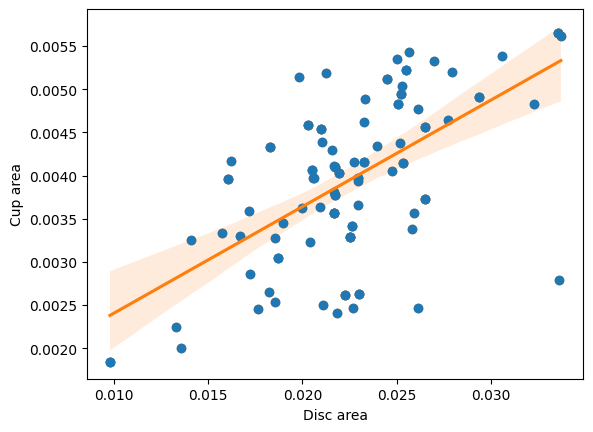

In [4]:
plt.plot(data["disc_area"], data["cup_area"], linestyle="",marker="o")
sns.regplot(x=data["disc_area"],y=data["cup_area"])
plt.xlabel("Disc area")
plt.ylabel("Cup area")

Text(0, 0.5, 'Cup diameter')

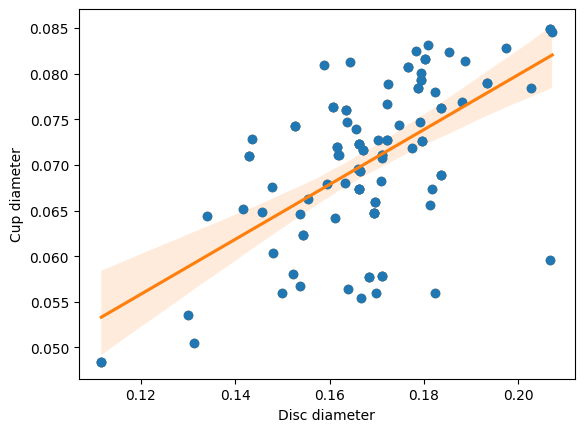

In [14]:
plt.plot(data["disc_diameter"], data["cup_diameter"], linestyle="",marker="o")
sns.regplot(x=data["disc_diameter"],y=data["cup_diameter"])
plt.xlabel("Disc diameter")
plt.ylabel("Cup diameter")
# sns.scatterplot(data=data["cup_diameter"])

<Axes: >

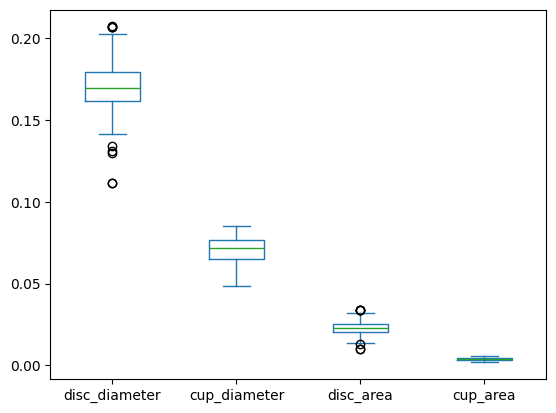

In [6]:
data.plot(kind="box")

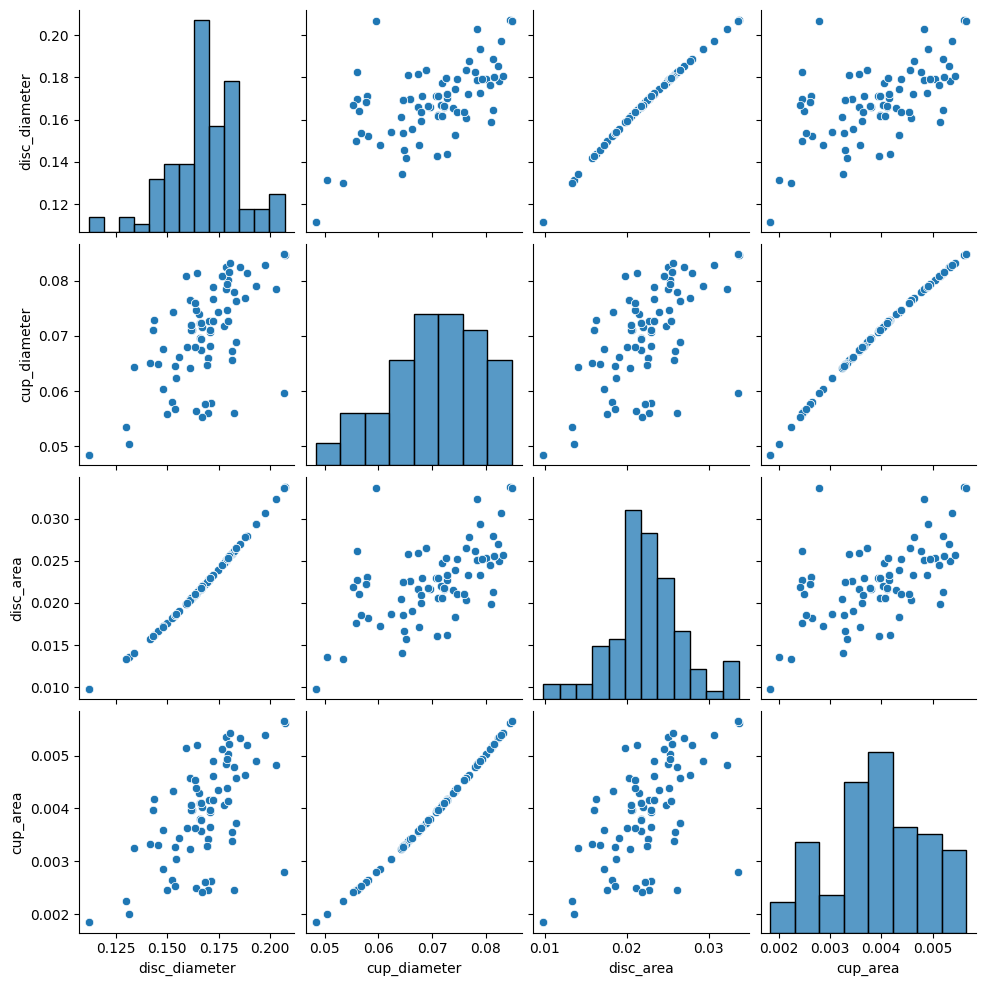

In [7]:
sns.pairplot(data=data)

In [8]:
def distance_line(x,y):
    m, c = np.polyfit(x, y, 1)
    # print(m)
    # print(c)
    distances = []
    for xi, yi in zip(x, y):
        distance = abs(m * xi - yi + c) / np.sqrt(m**2 + 1)
        distances.append(distance)
    # print(distances)
    distances = np.mean(distances)
    # print(distances)
    c_above = c + distances * np.sqrt(1 + m**2)
    c_below = c - distances * np.sqrt(1 + m**2)
    return m, c_below, c, c_above

In [9]:
def point_position_parallel(m, c1, c2, c3, point):
    x, y = point

    # Sort intercepts to determine bottom, middle, and top lines
    intercepts = sorted([(c1, "Line 1"), (c2, "Line 2"), (c3, "Line 3")])
    bottom_line, middle_line, top_line = intercepts

    # Calculate y-values for the given x-coordinate
    y_bottom = m * x + bottom_line[0]
    y_middle = m * x + middle_line[0]
    y_top = m * x + top_line[0]

    # Determine the position of the point relative to the lines
    if y < y_bottom:
        # return "The point is below all the lines."
        return 3
    elif y > y_top:
        # return "The point is above all the lines."
        return 0
    elif y_bottom < y < y_middle:
        # return f"The point is between {bottom_line[1]} and {middle_line[1]}."
        return 2
    elif y_middle < y < y_top:
        # return f"The point is between {middle_line[1]} and {top_line[1]}."
        return 1
    else:
        # return "The point lies exactly on one of the lines."
        return 1

In [10]:
answers = ["autistic", "might be autistic", "might not be autistic", "not autistic"]
ref = [0,0,0,0]

In [11]:
class RetinaFundusDataset(Dataset):
    def __init__(self, images_dir, annotations_dir=None, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])

        # Check if annotations are available
        if self.annotations_dir:
            annotation_name = os.path.join(self.annotations_dir, self.image_files[idx].replace('.jpg', '.json').replace('.png', '.json'))
            # Load annotations (bounding boxes)
            if os.path.exists(annotation_name):
                with open(annotation_name, 'r') as f:
                    annotations = json.load(f)

                # Extract bounding boxes for optic disc and optic cup
                disc_box = annotations['optic_disc']
                cup_box = annotations['optic_cup']

                # Extract height and width of the bounding boxes
                disc_height = disc_box['height']
                disc_width = disc_box['width']
                cup_height = cup_box['height']
                cup_width = cup_box['width']

                # Targets: height and width of optic disc and optic cup
                target = [disc_height, disc_width, cup_height, cup_width]
            else:
                target = torch.zeros(4)  # Default to zero if annotation file is missing
        else:
            # No annotations in test set
            target = torch.zeros(4)  # Dummy target for test set, no annotations required

        # Load image
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)
class RetinaModel(nn.Module):
    def __init__(self):
        super(RetinaModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)  # 4 outputs for height/width of optic disc and cup
    
    def forward(self, x):
        return self.resnet(x)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
input_images_dir = 'testing_images'  # Replace with the path to your folder

# Create dataset and dataloader for input images
input_dataset = RetinaFundusDataset(input_images_dir, transform=transform)
input_loader = DataLoader(input_dataset, batch_size=1, shuffle=False)

# Load the trained model
model = RetinaModel()  # Ensure this is your trained model class
model.load_state_dict(torch.load('retina_model.pth'))  # Load the saved model
model.eval()  # Set the model to evaluation mode


#function to check if the given data in an outlier

# Evaluate the model on input images
i=1
with torch.no_grad():
    for inputs, file_names in input_loader:
        outputs = model(inputs)
        
        # Extract predicted bounding boxes (height, width)
        disc_height, disc_width, cup_height, cup_width = abs(outputs[0])

        # Calculate the area of optic disc and optic cup
        disc_area = disc_height * disc_width
        cup_area = cup_height * cup_width

        # Display the results
        # print(f"Image: {file_names[0]}")
        print(f"Image {i}:")
        i+=1
        # print(f"Optic Disc - Height: {disc_height:.2f}, Width: {disc_width:.2f}, Area: {disc_area:.2f}")
        # print(f"Optic Cup - Height: {cup_height:.2f}, Width: {cup_width:.2f}, Area: {cup_area:.2f}")
        
        #**DELETE**
        #calculating the diameters and the areas
        disc_diameter = (disc_height+disc_width)/2
        cup_diameter = (cup_height+cup_width)/2
        DiscArea = np.pi*(disc_diameter/2)**2
        CupArea = np.pi*(cup_diameter/2)**2
        
        # classify=[DiscDiameterBound<=disc_diameter,CupDiameterBound<=cup_diameter,DiscAreaBound<=DiscArea,CupAreaBound<=CupArea]
        # print(classify)
        # print(disc_diameter,cup_diameter, DiscArea, CupArea)
        #area
        values = distance_line(data["disc_area"], data["cup_area"])
        result1 = point_position_parallel(values[0], values[1], values[2], values[3], (DiscArea,CupArea))
        
        #diameter
        values = distance_line(data["disc_diameter"], data["cup_diameter"])
        result2 = point_position_parallel(values[0], values[1], values[2], values[3], (disc_diameter,cup_diameter))
        if result1==result2:
            print(answers[result2])
        else:
            print(answers[2])
        

C:\Users\mdans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mdans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image 1:
not autistic
Image 2:
not autistic
Image 3:
autistic


C:\Users\mdans\AppData\Local\Temp\ipykernel_16260\2827165199.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('retina_model.pth'))  # Loa